# Explore Data in Experiment `20211202_72bar`

Note that the thresholds for analysis were determined based on `bubbletracking_koe/analysis/true_obj_vs_threshold.py`

In [1]:
%load_ext autoreload
%autoreload 2

# sets plotting font to Arial
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

# standard libraries
import os
import glob
import pickle as pkl

# 3rd party libraries
import numpy as np
import matplotlib.pyplot as plt

# custom libraries
import sys
sys.path.append('../../libs/')
import fn
import flow
import plot.bubble as pltb
from conversions import *

# comes after imports from ../../libs/ because I unfortunately 
# created files with the same name there and in ../src/
sys.path.append('../src/')
import objproc as op
import bubble
import analytics as an

### PARAMETERS ###
# directory template containing data files
data_dir_tmp = '../input/ppg_co2/20211202_72bar/*'
# data filename
data_filename = 'data.pkl'
# data for polyol-CO2 mixture 
# make this on Wang group server with `bi_surf`--read README.txt and copy 1k3f_22c.csv
polyol_data_file = '../input/3k2f_31c.csv'
# equation of state data for CO2 at desired temperature 
eos_co2_file = '../input/eos_co2_25-0C.csv'

## Plot Bubble Growth

Just until they start to elongate.

I plot the radius instead of the length or width because the length and width are discrete due to pixellation, whereas the fact that the radius is computed from the length and width allows it to take on more values and appear less discrete.

No handles with labels found to put in legend.


dict_keys(['objects', 'frame IDs', 'metadata'])
dict_keys(['objects', 'frame IDs', 'metadata'])
dict_keys(['objects', 'frame IDs', 'metadata'])
dict_keys(['objects', 'frame IDs', 'metadata'])
dict_keys(['objects', 'frame IDs', 'metadata'])


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


dict_keys(['objects', 'frame IDs', 'metadata'])
dict_keys(['objects', 'frame IDs', 'metadata'])
dict_keys(['objects', 'frame IDs', 'metadata'])
dict_keys(['objects', 'frame IDs', 'metadata'])
dict_keys(['objects', 'frame IDs', 'metadata'])
dict_keys(['objects', 'frame IDs', 'metadata'])
dict_keys(['objects', 'frame IDs', 'metadata'])


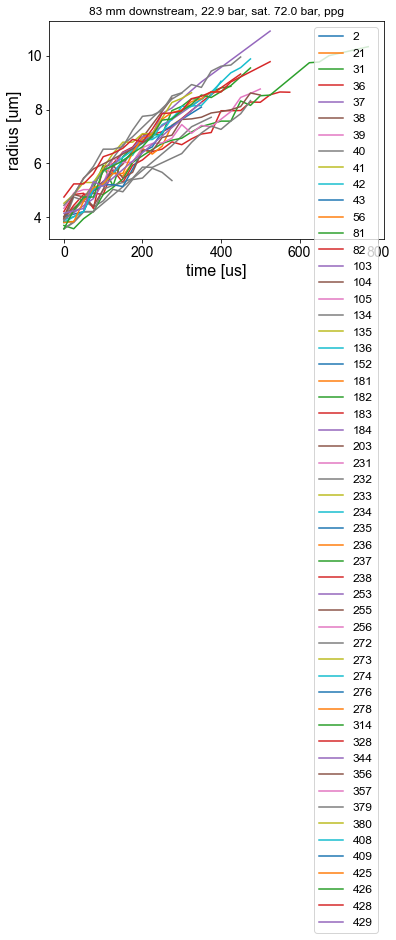

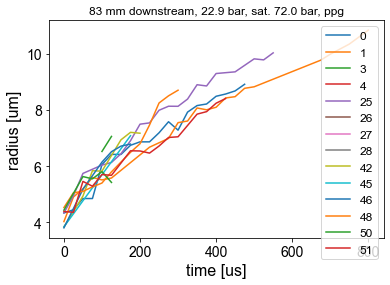

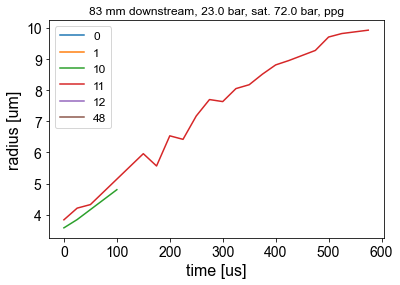

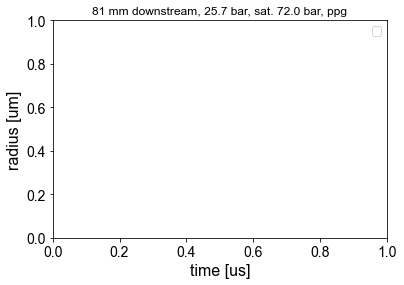

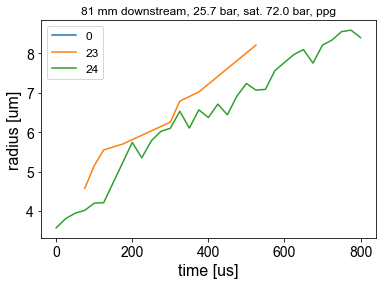

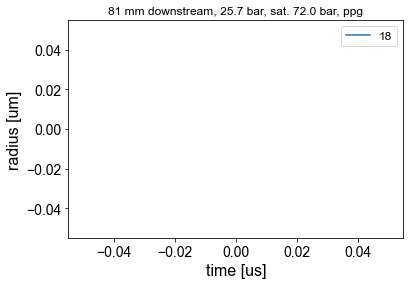

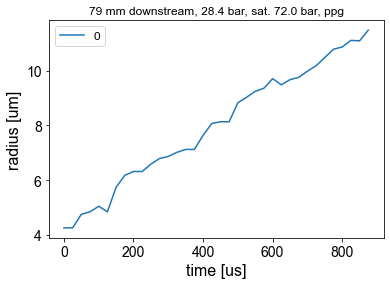

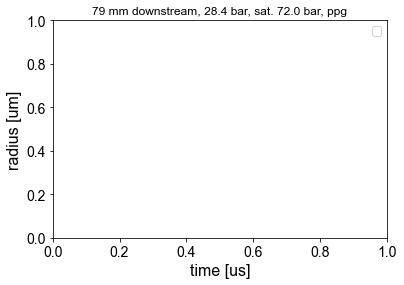

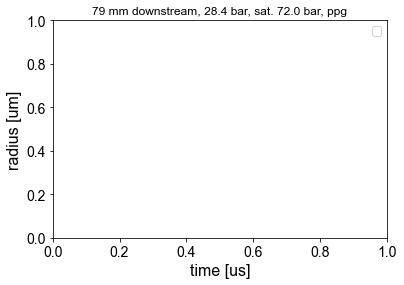

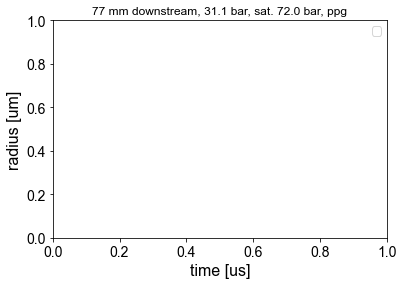

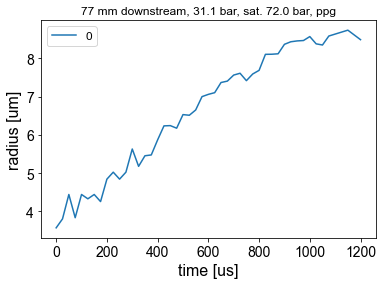

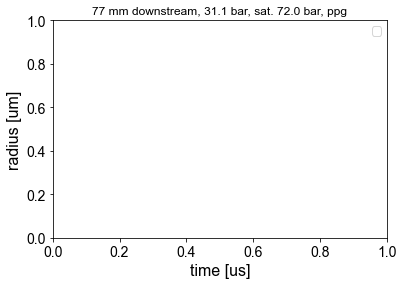

In [4]:
# plot parameters
ax_fs = 16
tk_fs = 14
l_fs = 12
# analysis parameters
W_frac = 0.5 # ignores all bubbles for which width is less than this fraction of length


# data structs to store bubble radii, etc.
# keys will be (num, ID), where num is video number and ID is bubble ID number
# values will be dictionaries of properties: time [s], radius [m], width [m], length [m],
# 
bubble_growth = {}

# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions
    # saturation pressure, distance along capillary, 
    # estimated local pressure, polyol
    p_in, p_sat, p_est, p_in, d, L, v_max, t_center, polyol = op.get_conditions(data['metadata'])

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
        
        # gets timeline of bubble (starts at zero) [s]
        frame_list = obj['props_raw']['frame']
        fps = obj['metadata']['fps']
        t = (np.asarray(frame_list) - frame_list[0]) / fps
        
        # gets bubble size
        R = np.asarray(obj['props_proc']['radius [um]'])
        L = np.asarray(op.calc_L(obj))
        W = np.asarray(op.calc_W(obj))
        
        # gets valid indices (eliminates where on border or where bubble is too long
        not_on_border = np.logical_not(np.asarray(obj['props_raw']['on border']))
        not_too_long = W > L*W_frac
        idx = np.logical_and(not_on_border, not_too_long)
        
        # plots bubble growth
        ax.plot(t[idx]*s_2_us, R[idx], label=str(ID))
        
        
    # formats plot
    ax.set_xlabel('time [us]', fontsize=ax_fs)
    ax.set_ylabel('radius [um]', fontsize=ax_fs)
    ax.tick_params(axis='both', labelsize=tk_fs)
    ax.legend(fontsize=l_fs)
    ax.set_title('{0:d} mm downstream, {1:.1f} bar, sat. {2:.1f} bar, {3:s}'\
                 .format(int(d*m_2_mm), p_est*Pa_2_bar, p_sat*Pa_2_bar, polyol))

## Fit Data to Bubble Growth Model to Estimate Nucleation Time

t_nuc = 96.501 ms and error in R is 0.9992.
t_nuc = 95.053 ms and error in R is 1.2208.
t_nuc = 95.777 ms and error in R is 0.5206.
t_nuc = 96.139 ms and error in R is 0.0090.
Error in bubble radius is below tolerance of 0.0100 for nucleation time t = 96.139 ms
Model prediction at fit point is R = 3.940775 um.


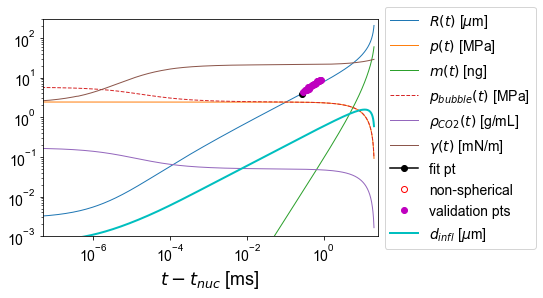

In [5]:
# analysis parameters
W_frac = 0.5 # ignores all bubbles for which width is less than this fraction of length
frac_lo = 0.97
frac_hi = 1.03
growth_fn = bubble.grow

# Epstein--Plesset params
# bubble growth model parameters
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]

# guess for effective diffusivity constant [m^2/s] TODO: fit this, too
D = 4E-9

# other params
i_t_nuc = 0
sigma_R = 0.01
max_iter = 25
i_t = 0
i_R = 8
dict_args = {'D' : D}


# number of bubbles to fit
n_fit = 1
ct = 0


# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    # loads data
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions of experiment
    p_in, p_sat, p_est, p_in, d, L, \
    v_max, t_center, polyol = op.get_conditions(data['metadata'])

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
            
        # time of observations of bubble since entering observation capillary [s]
        t_bub = op.calc_t(obj, d, v_max)
        
        # gets bubble size [um]
        W_bub = np.asarray(op.calc_W(obj))
        L_bub = np.asarray(op.calc_L(obj))
        # and radius [m]
        R_bub = np.asarray(obj['props_proc']['radius [um]']) * um_2_m
        
        # gets valid indices (eliminates where on border or where bubble is too long
        not_on_border = np.logical_not(np.asarray(obj['props_raw']['on border']))
        not_too_long = W_bub > L_bub * W_frac
        idx = np.logical_and(not_on_border, not_too_long)
        if not any(idx):
            continue
        
        # extracts only valid measurements
        t_bub = t_bub[idx]
        R_bub = R_bub[idx]
        
        # estimates bounds on nucleation time [s]
        t_nuc_lo = frac_lo*t_center
        t_nuc_hi = frac_hi*t_center
        
        # collects inputs
        eps_params = list((dt, p_sat, R_nuc, L, p_in, v_max, polyol_data_file, eos_co2_file))

        # fits nucleation time to data [s]
        t_nuc, output = an.fit_growth_to_pt(t_bub[0], R_bub[0], t_nuc_lo, t_nuc_hi, 
                                            growth_fn, eps_params, i_t_nuc, sigma_R=sigma_R, 
                                            max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args)
        # plots result
        R_i = data['metadata']['object_kwargs']['R_i'] # inner stream radius [m]
        ax = pltb.fit(t_nuc, output, t_bub, R_bub, R_i)
        
        ####### FIT D ######
             
        # ends loop when desired number of trajectories has been fit
        ct += 1
        if ct == n_fit:
            break
            
    if ct == n_fit:
        break

## Fit Diffusivity as Well as Nucleation Time

t_nuc = 96.501 ms and error in R is 0.9992.
t_nuc = 94.088 ms and error in R is 1.9532.
t_nuc = 95.294 ms and error in R is 1.1294.
t_nuc = 95.897 ms and error in R is 0.4751.
t_nuc = 96.199 ms and error in R is 0.0600.
t_nuc = 96.048 ms and error in R is 0.2385.
t_nuc = 96.124 ms and error in R is 0.1044.
t_nuc = 96.161 ms and error in R is 0.0210.
t_nuc = 96.180 ms and error in R is 0.0226.
t_nuc = 96.171 ms and error in R is 0.0041.
Error in bubble radius is below tolerance of 0.0200 for nucleation time t = 96.171 ms
D = 4.5e-09 m^2/s. rms = -0.006 is BELOW tolerance of 0.010.
Model prediction at fit point is R = 3.929069 um.
t_nuc = 96.501 ms and error in R is 1.0933.
t_nuc = 98.913 ms and error in R is 0.9992.
t_nuc = 97.707 ms and error in R is 0.9992.
t_nuc = 97.104 ms and error in R is 0.1983.
t_nuc = 97.405 ms and error in R is 0.9992.
t_nuc = 97.254 ms and error in R is 0.2033.
t_nuc = 97.179 ms and error in R is 0.0043.
Error in bubble radius is below tolerance of 0.0200 for

t_nuc = 96.501 ms and error in R is 0.9993.
t_nuc = 94.088 ms and error in R is 1.3962.
t_nuc = 95.294 ms and error in R is 0.3900.
t_nuc = 95.897 ms and error in R is 0.9993.
t_nuc = 95.596 ms and error in R is 0.0626.
t_nuc = 95.445 ms and error in R is 0.1806.
t_nuc = 95.520 ms and error in R is 0.0817.
t_nuc = 95.558 ms and error in R is 0.0000.
Error in bubble radius is below tolerance of 0.0200 for nucleation time t = 95.558 ms
D = 4.0625e-09 m^2/s. rms = 0.098 is ABOVE tolerance of 0.010.
Slope ratio = 1.064
t_nuc = 96.501 ms and error in R is 0.9993.
t_nuc = 94.088 ms and error in R is 1.3132.
t_nuc = 95.294 ms and error in R is 0.3519.
t_nuc = 95.897 ms and error in R is 0.9993.
t_nuc = 95.596 ms and error in R is 0.0958.
t_nuc = 95.445 ms and error in R is 0.1390.
t_nuc = 95.520 ms and error in R is 0.0472.
t_nuc = 95.558 ms and error in R is 0.0251.
t_nuc = 95.539 ms and error in R is 0.0175.
Error in bubble radius is below tolerance of 0.0200 for nucleation time t = 95.539 

t_nuc = 96.689 ms and error in R is 0.0185.
Error in bubble radius is below tolerance of 0.0200 for nucleation time t = 96.689 ms
D = 2.42187e-09 m^2/s. rms = 0.039 is ABOVE tolerance of 0.010.
Slope ratio = 1.037
t_nuc = 96.501 ms and error in R is 0.1886.
t_nuc = 98.913 ms and error in R is 0.9992.
t_nuc = 97.707 ms and error in R is 0.9992.
t_nuc = 97.104 ms and error in R is 0.9992.
t_nuc = 96.802 ms and error in R is 0.1814.
t_nuc = 96.651 ms and error in R is 0.0176.
Error in bubble radius is below tolerance of 0.0200 for nucleation time t = 96.651 ms
D = 2.36719e-09 m^2/s. rms = 0.035 is ABOVE tolerance of 0.010.
Slope ratio = 0.974
t_nuc = 96.501 ms and error in R is 0.1955.
t_nuc = 98.913 ms and error in R is 0.9992.
t_nuc = 97.707 ms and error in R is 0.9992.
t_nuc = 97.104 ms and error in R is 0.9992.
t_nuc = 96.802 ms and error in R is 0.1767.
t_nuc = 96.651 ms and error in R is 0.0211.
t_nuc = 96.727 ms and error in R is 0.0628.
t_nuc = 96.689 ms and error in R is 0.0241.


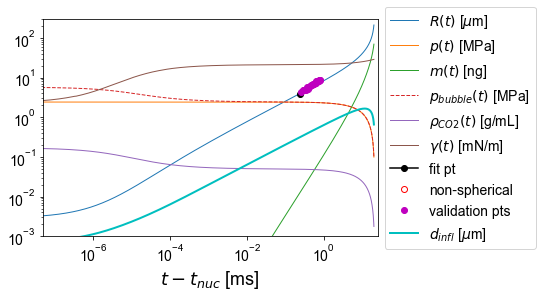

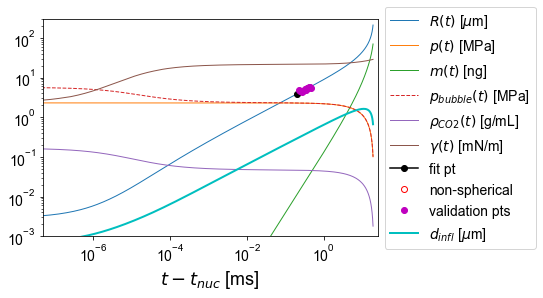

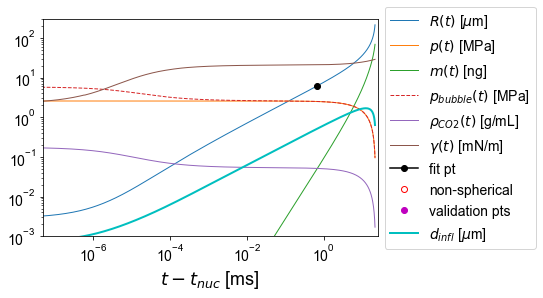

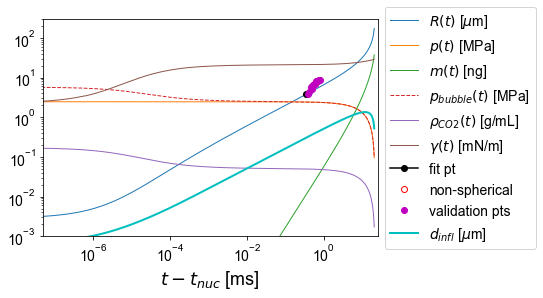

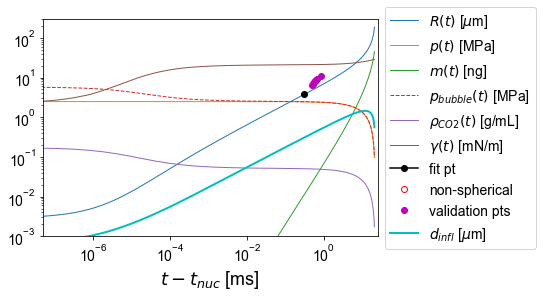

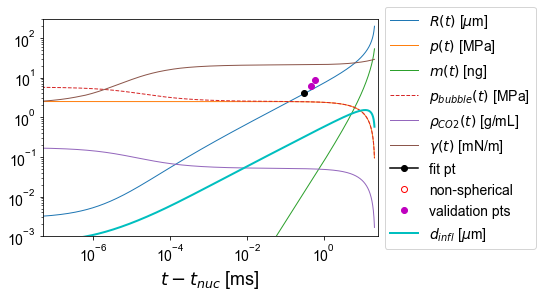

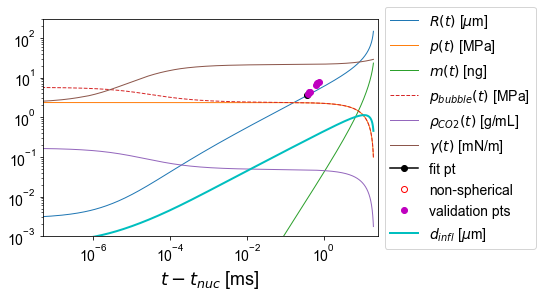

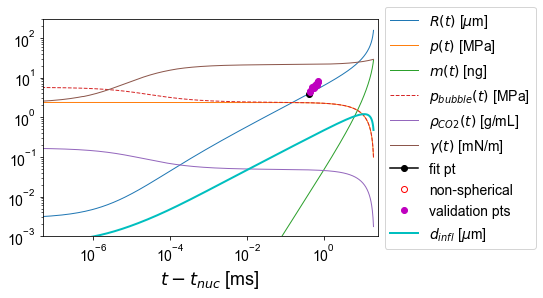

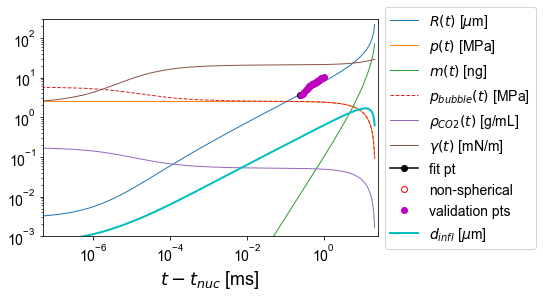

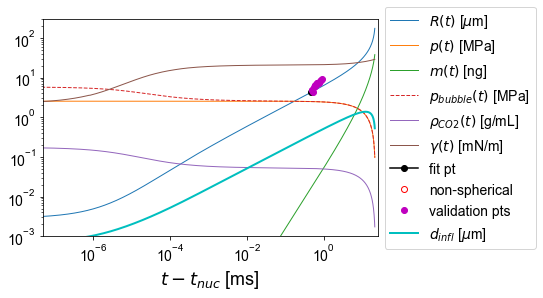

In [9]:
# analysis parameters
W_frac = 0.5 # ignores all bubbles for which width is less than this fraction of length
frac_lo = 0.95
frac_hi = 1.05
growth_fn = bubble.grow

# Epstein--Plesset params
# bubble growth model parameters
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]

# guess for effective diffusivity constant [m^2/s] TODO: fit this, too
D_min = 1E-9
D_max = 8E-9

# other params
i_t_nuc = 0
sigma_R = 0.02
rms_tol = 0.01 # keep high--this is used to fit D, must allow for noise in data
slope_tol = 0.01
max_iter = 15
i_t = 0
i_R = 8

x_lim = [1E-2, 30]
y_lim = [1E-1, 100]


# number of bubbles to fit
n_fit = 10
ct = 0


# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    # loads data
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions of experiment
    p_in, p_sat, p_est, p_in, d, L, \
    v_max, t_center, polyol = op.get_conditions(data['metadata'])

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
            
        # time of observations of bubble since entering observation capillary [s]
        t_bub = op.calc_t(obj, d, v_max)
        
        # gets bubble size [um]
        W_bub = np.asarray(op.calc_W(obj))
        L_bub = np.asarray(op.calc_L(obj))
        # and radius [m]
        R_bub = np.asarray(obj['props_proc']['radius [um]']) * um_2_m
        
        # gets valid indices (eliminates where on border or where bubble is too long
        not_on_border = np.logical_not(np.asarray(obj['props_raw']['on border']))
        not_too_long = W_bub > L_bub * W_frac
        idx = np.logical_and(not_on_border, not_too_long)
        if not any(idx):
            continue
        
        # extracts only valid measurements
        t_bub = t_bub[idx]
        R_bub = R_bub[idx]
        
        # estimates bounds on nucleation time [s]
        t_nuc_lo = frac_lo*t_center
        t_nuc_hi = frac_hi*t_center

        # sets moveable limits on effective diffusivity for binary search
        D_min_tmp = D_min
        D_max_tmp = D_max
        for ct_iter in range(max_iter):
            
            # makes guess for effective diffusivity constant
            D = (D_min_tmp + D_max_tmp) / 2
            # packages it for solver
            dict_args = {'D' : D}
            
            # collects inputs -- must recollect after an.fit_growth_to_pt b/c it inserts t_nuc
            eps_params = list((dt, p_sat, R_nuc, L, p_in, v_max, polyol_data_file, eos_co2_file))
            
            # fits nucleation time to data [s]
            t_nuc, output = an.fit_growth_to_pt(t_bub[0], R_bub[0], t_nuc_lo, t_nuc_hi, 
                                                growth_fn, eps_params, i_t_nuc, sigma_R=sigma_R, 
                                                max_iter=max_iter, i_t=i_t, i_R=i_R, dict_args=dict_args,
                                               x_lim=x_lim, y_lim=y_lim)
            
            
            # rms from t^1/2 fit
            t_fit = output[0]
            R_fit = output[-2]
            a, b = np.polyfit( np.log(t_fit[1:] - t_nuc), np.log(R_fit[1:]), 1 )
            R_power_law = np.exp(b) * (t_fit - t_nuc)**a
            rms_data = an.calc_rms_err(t_fit[1:], R_power_law[1:], t_fit, R_fit)
            # computes rms of fit
            rms_err = an.calc_rms_err(t_bub, R_bub, t_fit, R_fit)
            rms_excess = rms_err - rms_data
            
            if rms_excess < rms_tol:
                print('D = {0:g} m^2/s. rms = {1:.3f} is BELOW tolerance of {2:.3f}.'.format(D, rms_excess, rms_tol))
                break
            else:
                print('D = {0:g} m^2/s. rms = {1:.3f} is ABOVE tolerance of {2:.3f}.'.format(D, rms_excess, rms_tol))
                # compares slopes of fit and data
                slope_fit, _ = np.polyfit( np.sqrt(t_fit - t_nuc), R_fit, 1 )
                slope_meas, _ = np.polyfit( np.sqrt(t_bub - t_nuc), R_bub, 1 )
                slope_ratio = slope_fit / slope_meas
                
                if np.abs(slope_ratio - 1) < slope_tol:
                    print('Slope ratio {0:.3f} deviates from 1 by less than tolerance {1:.3f}.' \
                          .format(slope_ratio, slope_tol))
                    break
                    
                print('Slope ratio = {0:.3f}'.format(slope_ratio))
                # decreases D if fitted slope is too high
                if slope_ratio > 1:
                    D_max_tmp = D
                # increases D if fitted slope is too low
                else:
                    D_min_tmp = D
                
            
        # plots result
        R_i = data['metadata']['object_kwargs']['R_i'] # inner stream radius [m]
        ax = pltb.fit(t_nuc, output, t_bub, R_bub, R_i)
        
        # stores results -- TODO
        # t_nuc, d_nuc, output, D
             
        # ends loop when desired number of trajectories has been fit
        ct += 1
        if ct == n_fit:
            break
            
    if ct == n_fit:
        break

## Fit Growth to Multiple Points

In [29]:
# OBJECT FILTER PARAMETERS
W_frac = 0.5 # ignores all bubbles for which width is less than this fraction of length

# BUBBLE GROWTH MODEL PARAMETERS
frac_lo = 0.95
frac_hi = 1.05
growth_fn = bubble.grow
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]
i_t_nuc = 0 # index of nucleation time in input parameters
i_t = 0 # index of time in output
i_R = -2 # index of predicted radius in output

# FITTING PARAMETERS
# guess for effective diffusivity constant [m^2/s]
D_min = 1E-9
D_max = 8E-9
tol = 0.003
err_fn = an.calc_abs_sgn_mse
rms_tol = -0.02 # keep high--this is used to fit D, must allow for noise in data
slope_tol = 0.01
max_iter = 15

# PLOTTING PARAMETERS
x_lim = [1E-2, 10]
y_lim = [1, 30]


# USER PARAMETERS
# number of bubbles to fit
n_fit = 1


# initializes count of profiles fit
ct = 0

# loads data from each file
data_dir_list = glob.glob(data_dir_tmp)
for data_dir in data_dir_list:
    # loads data
    with open(os.path.join(data_dir, data_filename), 'rb') as f:
        data = pkl.load(f)
        
    # gets conditions of experiment
    p_in, p_sat, p_est, p_in, d, L, \
    v_max, t_center, polyol = op.get_conditions(data['metadata'])

    # gets sizes of each bubble
    for ID, obj in data['objects'].items():
        # skips objects that are not definitely real objects (bubbles)
        if not op.is_true_obj(obj):
            continue
            
        # time of observations of bubble since entering observation capillary [s]
        t_bub = op.calc_t(obj, d, v_max)
        
        # gets bubble size [um]
        W_bub = np.asarray(op.calc_W(obj))
        L_bub = np.asarray(op.calc_L(obj))
        # and radius [m]
        R_bub = np.asarray(obj['props_proc']['radius [um]']) * um_2_m
        
        # gets valid indices (eliminates where on border or where bubble is too long
        not_on_border = np.logical_not(np.asarray(obj['props_raw']['on border']))
        not_too_long = W_bub > L_bub * W_frac
        idx = np.logical_and(not_on_border, not_too_long)
        if not any(idx):
            continue
        
        # extracts only valid measurements
        t_bub = t_bub[idx]
        R_bub = R_bub[idx]
        
        # estimates bounds on nucleation time [s]
        t_nuc_lo = frac_lo*t_center
        t_nuc_hi = frac_hi*t_center

        # sets moveable limits on effective diffusivity for binary search
        D_min_tmp = D_min
        D_max_tmp = D_max
        for ct_iter in range(max_iter):
            
            # makes guess for effective diffusivity constant
            D = (D_min_tmp + D_max_tmp) / 2
            # packages it for solver
            dict_args = {'D' : D}
            
            # collects inputs -- must recollect after an.fit_growth_to_pt b/c it inserts t_nuc
            eps_params = list((dt, p_sat, R_nuc, L, p_in, v_max, polyol_data_file, eos_co2_file))
            
            # fits nucleation time to data [s]
            t_nuc, output = an.fit_growth_to_pts(t_bub, R_bub, t_nuc_lo, t_nuc_hi, 
                                                growth_fn, eps_params, i_t_nuc, err_fn, tol, 
                                                max_iter=max_iter, dict_args=dict_args)
            
            
            # rms from t^1/2 fit
            t_fit = output[i_t]
            R_fit = output[i_R]
            a, b = np.polyfit( np.log(t_fit[1:] - t_nuc), np.log(R_fit[1:]), 1 )
            R_power_law = np.exp(b) * (t_fit - t_nuc)**a
            rms_data = an.calc_rms_err(t_fit[1:], R_power_law[1:], t_fit, R_fit)
            # computes rms of fit
            rms_err = an.calc_rms_err(t_bub, R_bub, t_fit, R_fit)
            rms_excess = rms_err - rms_data
            
            if rms_excess < rms_tol:
                print('D = {0:g} m^2/s. rms = {1:.3f} is BELOW tolerance of {2:.3f}.'.format(D, rms_excess, rms_tol))
                break
            else:
                print('D = {0:g} m^2/s. rms = {1:.3f} is ABOVE tolerance of {2:.3f}.'.format(D, rms_excess, rms_tol))
                # compares slopes of fit and data
                slope_fit, _ = np.polyfit( np.log(t_fit[1:] - t_nuc), np.log(R_fit[1:]), 1 )
                slope_meas, _ = np.polyfit( np.log(t_bub - t_nuc), np.log(R_bub), 1 )
                slope_ratio = slope_fit / slope_meas
                
                if np.abs(slope_ratio - 1) < slope_tol:
                    print('Slope ratio {0:.3f} deviates from 1 by less than tolerance {1:.3f}.' \
                          .format(slope_ratio, slope_tol))
                    break
                    
                print('Slope ratio = {0:.3f}'.format(slope_ratio))
                # decreases D if fitted slope is too high
                if slope_ratio > 1:
                    D_max_tmp = D
                # increases D if fitted slope is too low
                else:
                    D_min_tmp = D
                
            
        # plots result
        R_i = data['metadata']['object_kwargs']['R_i'] # inner stream radius [m]
        ax = pltb.fit(t_nuc, output, t_bub, R_bub, R_i)
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        
        # stores results -- TODO
        # t_nuc, d_nuc, output, D
             
        # ends loop when desired number of trajectories has been fit
        ct += 1
        if ct == n_fit:
            break
            
    if ct == n_fit:
        break

NameError: name 'data' is not defined

Originally compared pre-factor of $t^{1/2}$ fit and it converged on an effective diffusivity that resulted in a predicted growth that did not match the slope (on a log-log plot) of the measured data.
Revised algorithm for fitting the effective diffusivity to compare slope on log-log plot and fit was much better of slope on log-log plot (lesson: optimize the quantity you want to be optimized with no other constraints).

In [52]:
data_dir_list = glob.glob(data_dir_tmp)

growth_fn = bubble.grow
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]
i_t_nuc = 0 # index of nucleation time in input parameters
i_t = 0 # index of time in output
i_R = -2 # index of predicted radius in output

# FITTING PARAMETERS
# guess for effective diffusivity constant [m^2/s]
D_lo = 1E-9
D_hi = 8E-9
tol = 0.003
err_fn = an.calc_abs_sgn_mse
rms_tol = -0.02 # keep high--this is used to fit D, must allow for noise in data
slope_tol = 0.01
max_iter = 15

# PLOTTING PARAMETERS
x_lim = [1E-2, 10]
y_lim = [1, 30]


def fit_D_t_nuc(data_filename, data_dir_list, frac_lo, frac_hi, 
                D_lo, D_hi, growth_fn, dt, R_nuc, err_fn, err_tol,
                rms_tol, exp_ratio_tol, n_fit=-1, i_t_nuc=0, i_t=0, i_R=-2, 
                max_iter=15, W_frac=0.5, x_lim=None, y_lim=None, min_data_pts=4):
    """
    Fits effective diffusivity D and nucleation time t_nuc.
    
    TODO: select t_nuc_lo and t_nuc_hi with absolute deviation 
    from t_center instead of fractional since deviation should 
    not depend on time traveling through observation capillary.
    """
    # initializes lists to store outputs
    t_nuc_list = []
    d_nuc_list = []
    output_list = []
    D_list = []
    
    ct = 0

    # loads data from each file
    for data_dir in data_dir_list:
        # loads data
        with open(os.path.join(data_dir, data_filename), 'rb') as f:
            data = pkl.load(f)

        # gets conditions of experiment
        p_in, p_sat, p_est, p_in, d, L, \
        v_max, t_center, polyol = op.get_conditions(data['metadata'])

        # gets sizes of each bubble
        for ID, obj in data['objects'].items():
            # skips objects that are not definitely real objects (bubbles)
            if not op.is_true_obj(obj):
                continue

            # time of observations of bubble since entering observation capillary [s]
            t_bub = op.calc_t(obj, d, v_max)
            # bubble radius [m]
            R_bub = np.asarray(obj['props_proc']['radius [um]']) * um_2_m
            
            # gets indices of frames for bubble's fully visible early growth
            idx = op.get_valid_idx(obj)
            # skips bubbles for which not enough frames of early growth were observed
            if len(t_bub[idx]) < min_data_pts:
                continue
            # extracts only valid measurements
            t_bub = t_bub[idx]
            R_bub = R_bub[idx]
            
            # estimates bounds on nucleation time [s]
            t_nuc_lo = frac_lo*t_center
            t_nuc_hi = frac_hi*t_center

            # sets moveable limits on effective diffusivity for binary search
            D_lo_tmp = D_lo
            D_hi_tmp = D_hi
            for _ in range(max_iter):

                # makes guess for effective diffusivity constant
                D = (D_lo_tmp + D_hi_tmp) / 2
                # packages it for solver
                dict_args = {'D' : D}
                # collects inputs -- must recollect after an.fit_growth_to_pt b/c it inserts t_nuc
                eps_params = list((dt, p_sat, R_nuc, L, p_in, v_max, polyol_data_file, eos_co2_file))

                # fits nucleation time to data [s]
                t_nuc, output = an.fit_growth_to_pts(t_bub, R_bub, t_nuc_lo, t_nuc_hi, 
                                                    growth_fn, eps_params, i_t_nuc, err_fn, err_tol, 
                                                    max_iter=max_iter, dict_args=dict_args)


                # extracts model values for time and radius
                t_fit = output[i_t]
                R_fit = output[i_R]
                
#                 # excess RMS
#                 rms_excess = an.calc_rms_excess(t_nuc, t_fit, R_fit, t_bub, R_bub)

#                 if rms_excess < rms_tol:
#                     print('D = {0:g} m^2/s. rms = {1:.3f} is BELOW tolerance of {2:.3f}.'\
#                           .format(D, rms_excess, rms_tol))
#                     break
#                 else:
#                     print('D = {0:g} m^2/s. rms = {1:.3f} is ABOVE tolerance of {2:.3f}.'\
#                           .format(D, rms_excess, rms_tol))
                
                # compares slopes of fit and data
                exp_ratio = an.calc_exp_ratio(t_nuc, t_fit, R_fit, t_bub, R_bub)

                if np.abs(exp_ratio - 1) < exp_ratio_tol:
                    print('Exponent ratio {0:.3f} deviates from 1 by less than tolerance {1:.3f}.' \
                          .format(exp_ratio, exp_ratio_tol))
                    break

                print('Exponent ratio = {0:.3f}'.format(exp_ratio))
                D_lo_tmp, D_hi_tmp = an.update_bounds_D(exp_ratio, D, D_lo_tmp, D_hi_tmp)


            # plots result
            R_i = data['metadata']['object_kwargs']['R_i'] # inner stream radius [m]
            ax = pltb.fit(t_nuc, output, t_bub, R_bub, R_i)
            if x_lim:
                ax.set_xlim(x_lim)
            if y_lim:
                ax.set_ylim(y_lim)

            # stores results
            t_nuc_list += [t_nuc]
            d_nuc_list += [t_nuc / v_max]
            output_list += [output]
            D_list += [D]

            # ends loop when desired number of trajectories has been fit
            ct += 1
            if ct == n_fit:
                break
                
        # must break out of two for loops when complete
        if ct == n_fit:
            break
            
    return t_nuc_list, d_nuc_list, output_list, D_list

t_nuc = 96.501 ms. Error is 0.0752 and tol is 0.0030.
t_nuc = 94.088 ms. Error is 0.1231 and tol is 0.0030.
t_nuc = 95.294 ms. Error is 0.0612 and tol is 0.0030.
t_nuc = 95.897 ms. Error is 0.0180 and tol is 0.0030.
t_nuc = 96.199 ms. Error is 0.0231 and tol is 0.0030.
t_nuc = 96.048 ms. Error is 0.0093 and tol is 0.0030.
t_nuc = 95.973 ms. Error is 0.0099 and tol is 0.0030.
t_nuc = 96.011 ms. Error is 0.0017 and tol is 0.0030.
Error 0.0017 is below tolerance of 0.0030 for nucleation time t = 96.011 ms
D = 4.5e-09 m^2/s. rms = 0.008 is ABOVE tolerance of -0.020.
0.0
43
0.5523081869597516
0.7390751218588089
Exponent ratio = 0.747
t_nuc = 96.501 ms. Error is 0.0654 and tol is 0.0030.
t_nuc = 94.088 ms. Error is 0.1693 and tol is 0.0030.
t_nuc = 95.294 ms. Error is 0.0952 and tol is 0.0030.
t_nuc = 95.897 ms. Error is 0.0407 and tol is 0.0030.
t_nuc = 96.199 ms. Error is 0.0042 and tol is 0.0030.
t_nuc = 96.350 ms. Error is 0.0253 and tol is 0.0030.
t_nuc = 96.274 ms. Error is 0.0112 and 

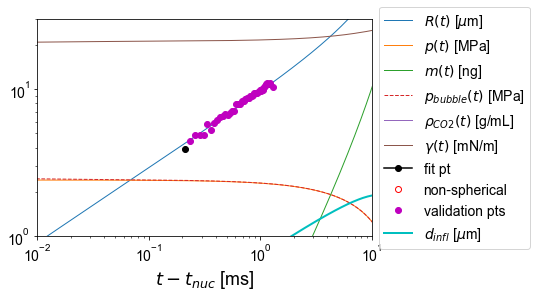

In [53]:
# GROWTH MODEL PARAMETERS
growth_fn = bubble.grow
dt = 1E-10 # [s]
R_nuc = 3E-9 # higher value bypasses numerical challenges at nm scale [m]

# FITTING PARAMETERS
frac_lo = 0.95
frac_hi = 1.05
# guess for effective diffusivity constant [m^2/s]
D_lo = 1E-9
D_hi = 8E-9
err_tol = 0.003
err_fn = an.calc_abs_sgn_mse
rms_tol = -0.02 # keep high--this is used to fit D, must allow for noise in data
exp_ratio_tol = 0.01

# PLOTTING PARAMETERS
x_lim = [1E-2, 10]
y_lim = [1, 30]

# USER PARAMETERS
n_fit = 1

# globs list of data directories
data_dir_list = glob.glob(data_dir_tmp)

# fits effective diffusivity D and nucleation time t_nuc
t_nuc_list, d_nuc_list, \
output_list, D_list = fit_D_t_nuc(data_filename, data_dir_list, frac_lo, frac_hi, 
                                    D_lo, D_hi, growth_fn, dt, R_nuc, err_fn, err_tol,
                                    rms_tol, exp_ratio_tol, n_fit=n_fit, x_lim=x_lim, y_lim=y_lim)